# Import data/libraries

Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CSV_PATH = r"/content/drive/MyDrive/Master Thesis Project/brics csv files/south_africa_data.csv"
data = pd.read_csv(CSV_PATH)

data['Year'] = pd.to_numeric(data['Year'])
data.sort_values('Year', inplace=True)
data.set_index('Year', inplace=True)

# Scale GDP to trillions for better numerical stability
data['GDP'] = data['GDP'] / 1e12

gdp = data['GDP']

# Feature Engineering

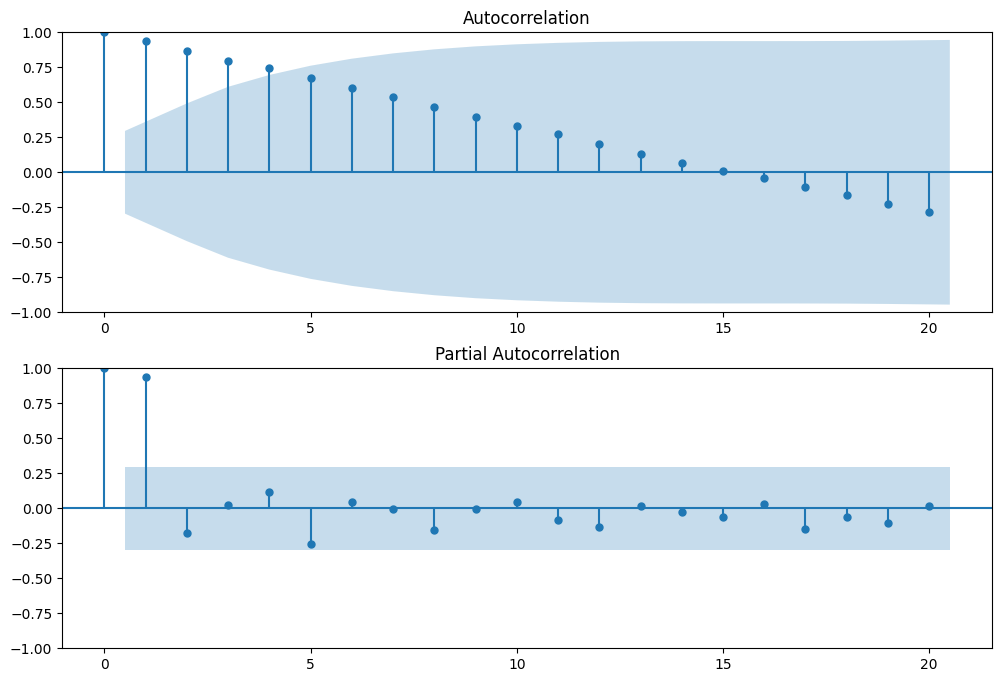

In [ ]:
# 1992: Post-Soviet transition shock
data['post_soviet'] = 0
data.loc[data.index.isin([1991,1995]), 'post_soviet'] = 1

# 1998: Financial crisis shock
data['financial_crisis'] = 0
data.loc[data.index == 1998, 'financial_crisis'] = 1

# 2003: Recovery phase shock
data['recovery'] = 0
data.loc[data.index.isin([2000,2003]), 'recovery'] = 1

# 2014: Sanctions following the annexation of Crimea
data['sanctions'] = 0
data.loc[data.index == 2014, 'sanctions'] = 1

# 2020: COVID-19 pandemic shock
data['COVID'] = 0
data.loc[data.index.isin([2020,2021]), 'COVID'] = 1

# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data['GDP'], lags=20, ax=axes[0])
plot_pacf(data['GDP'], lags=20, ax=axes[1])
plt.show()

Split Data

In [ ]:
#use data up to 2018 for training and 2019-2023 for testing.
train = gdp.loc[:2018]
test  = gdp.loc[2019:2023]

train_exog = data.loc[:2018, ['COVID','post_soviet', 'financial_crisis', 'recovery', 'sanctions']]
test_exog  = data.loc[2019:2023, ['COVID','post_soviet', 'financial_crisis', 'recovery', 'sanctions']]

# Model Training

In [ ]:
sarimax_order = (1, 1, 1)
sarimax_model = SARIMAX(train, exog=train_exog, order=sarimax_order,
                        enforce_stationarity=False, enforce_invertibility=False)
sarimax_result = sarimax_model.fit(disp=False)

# In-sample predictions (for training period)
train_pred = sarimax_result.fittedvalues

# Compute residuals (errors) on the training set.
train_resid = train - train_pred

# Calculate AIC and BIC
aic = sarimax_result.aic
bic = sarimax_result.bic
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

AIC: -156.90
BIC: -144.23


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Lag Features for XGBoost

In [ ]:
LAG_ORDER = 2
def create_lag_features(series, lags):
    df_lags = pd.DataFrame()
    for i in range(1, lags + 1):
        df_lags[f'lag_{i}'] = series.shift(i)
    df_lags['target'] = series
    return df_lags.dropna()

lagged_df = create_lag_features(train_resid, LAG_ORDER)
X_train = lagged_df[[f'lag_{i}' for i in range(1, LAG_ORDER + 1)]]
y_train = lagged_df['target']

Fitting XGBoost

In [ ]:
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.2 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [ ]:
xgb_model = XGBRegressor(objective = "reg:squarederror", n_estimators=100, random_state=42, verbosity=1)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Model Evaluation

In [ ]:
n_test = len(test)

sarimax_forecast_test = sarimax_result.get_forecast(steps=n_test,exog=test_exog)
sarimax_pred_test = sarimax_forecast_test.predicted_mean
sarimax_conf_int_test = sarimax_forecast_test.conf_int(alpha=0.05)

last_resids = train_resid.iloc[-LAG_ORDER:].tolist()
xgb_adjustments_test = []

current_lags = last_resids.copy()
for i in range(n_test):
    # Construct feature vector
    X_feature = np.array([current_lags[-1], current_lags[-2]]).reshape(1, -1)
    adjustment = xgb_model.predict(X_feature)[0]
    xgb_adjustments_test.append(adjustment)
    # Update the lags
    current_lags.append(adjustment)
    current_lags.pop(0)

# Combine the SARIMAX forecast and the XGBoost adjustment.
final_pred_test = sarimax_pred_test.values + np.array(xgb_adjustments_test)

# Evaluate predictions
mse = mean_squared_error(test, final_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, final_pred_test)

print("Evaluation Metrics on Test Set:")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")

Evaluation Metrics on Test Set:
AIC: -156.90
BIC: -144.23
MSE:  0.00
RMSE: 0.02
MAE:  0.02


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Future Forecast

In [ ]:
forecast_steps = 10
future_exog = pd.DataFrame({
    'COVID': [0] * forecast_steps,
    'post_soviet': [0] * forecast_steps,
    'financial_crisis': [0] * forecast_steps,
    'recovery': [0] * forecast_steps,
    'sanctions':[0] * forecast_steps},
    index=np.arange(2024, 2024 + forecast_steps))
sarimax_forecast_future = sarimax_result.get_forecast(steps=forecast_steps, exog=future_exog)
sarimax_pred_future = sarimax_forecast_future.predicted_mean
sarimax_conf_int_future = sarimax_forecast_future.conf_int(alpha=0.05)

# For the future, continue the recursive XGBoost adjustment.
# For initial lags, use the last two predicted adjustments from the test period if available,
# otherwise fall back on the last training residuals.
if len(xgb_adjustments_test) >= LAG_ORDER:
    current_lags = xgb_adjustments_test[-LAG_ORDER:].copy()
else:
    current_lags = last_resids.copy()

xgb_adjustments_future = []
for i in range(forecast_steps):
    X_feature = np.array([current_lags[-1], current_lags[-2]]).reshape(1, -1)
    adjustment = xgb_model.predict(X_feature)[0]
    xgb_adjustments_future.append(adjustment)
    current_lags.append(adjustment)
    current_lags.pop(0)

# Final combined forecast
final_pred_future = sarimax_pred_future.values + np.array(xgb_adjustments_future)
final_lower_future = sarimax_conf_int_future.iloc[:, 0].values + np.array(xgb_adjustments_future)
final_upper_future = sarimax_conf_int_future.iloc[:, 1].values + np.array(xgb_adjustments_future)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Potting results

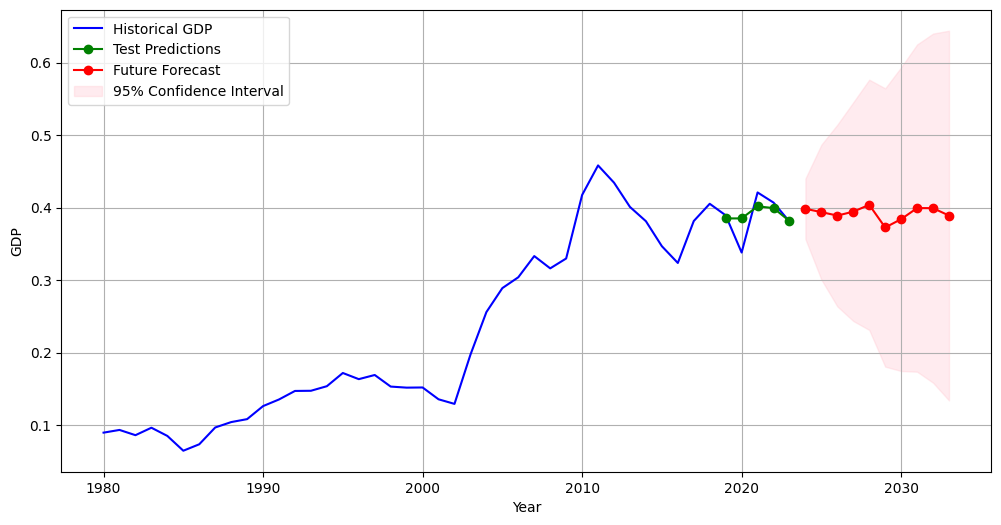

GDP Forecasts (Trillions USD):
2024: $0.40
2025: $0.39
2026: $0.39
2027: $0.39
2028: $0.40
2029: $0.37
2030: $0.38
2031: $0.40
2032: $0.40
2033: $0.39


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(gdp.index, gdp.values, label="Historical GDP", color='blue')
plt.plot(test.index, final_pred_test, label="Test Predictions", color='green', marker='o')
future_years = np.arange(2024, 2024 + forecast_steps)
plt.plot(future_years, final_pred_future, label="Future Forecast", color='red', marker='o')
plt.fill_between(future_years, final_lower_future, final_upper_future, color='pink', alpha=0.3, label="95% Confidence Interval")

plt.xlabel("Year")
plt.ylabel("GDP")
plt.legend()
plt.grid(True)
plt.show()

# Print the GDP forecasts
print("GDP Forecasts (Trillions USD):")
for year, gdp_pred in zip(future_years, final_pred_future):
    print(f"{year}: ${gdp_pred:.2f}")